# Norwegian Seafood Industry - Analytics Report

This report analyzes key aspects of the Norwegian Seafood Industry through data-driven approaches, focusing on four main areas:

1. **Demand & Supply Forecasting** - Integrating seasonal variations, environmental factors, and consumer behavior
2. **Inventory Management & Safety Stock Optimization** - Strategies for balancing freshness and cost
3. **Supply Chain & Network Optimization** - Enhancing distribution efficiency through data-driven approaches
4. **Case Study: 2010 Volcanic Eruption Impact** - Analysis of a major supply chain disruption event

## Data Sources & Setup

This analysis uses several data sources:

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import glob
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Blues_r')
plt.rcParams['figure.figsize'] = (12, 6)

**Primary Data Sources:**

1. **Global Fishing Watch AIS Data** - Fishing vessel activity with temporal and spatial dimensions (2012-2024)
2. **Statistics Norway (SSB) StatBank** - Seafood production, trade and transport time series
3. **NOAA OISST** - Global Sea Surface Temperature data (relevant for fishing conditions)
4. **UN Comtrade** - Global seafood trade flows (especially valuable for the volcanic eruption case study)

In [8]:
# Load fishing vessel AIS data (we'll load one month as example)
sample_file = r"C:\Users\Isak\Desktop\SupplyChain_seafood_project\fishing_vessel_AIS_2021_2024\fleet-monthly-csvs-10-v3-2021-01-01.csv"
ais_data = pd.read_csv(sample_file)

# Display the first few rows to understand the structure
print(f"Loaded data from {os.path.basename(sample_file)}")
ais_data.head()

Loaded data from fleet-monthly-csvs-10-v3-2021-01-01.csv


,date,year,month,cell_ll_lat,cell_ll_lon,flag,geartype,hours,fishing_hours,mmsi_present
0,2021-01-01,2021,1,20.7,111.1,ABW,trawlers,0.4097,0.4097,1
1,2021-01-01,2021,1,20.7,111.2,ABW,trawlers,1.4997,1.4997,1
2,2021-01-01,2021,1,20.7,111.3,ABW,trawlers,0.8330,0.8330,1
3,2021-01-01,2021,1,20.8,111.2,ABW,trawlers,0.2502,0.2502,1
4,2021-01-01,2021,1,20.8,111.1,ABW,trawlers,0.5738,0.5738,1


## 1. Integrated Demand & Supply Forecasting

### 1.1 Key Factors Affecting Seafood Demand & Supply

Seafood demand forecasting is influenced by multiple interconnected factors:

- **Seasonal Patterns**: Holiday periods (Christmas, Easter) and tourism seasons
- **Environmental Conditions**: Sea temperature, weather effects on fishing conditions
- **Consumer Behavior**: Sustainability preferences, price sensitivity, substitution effects
- **Supply Factors**: Fishing vessel activity, production capacity, regulations

Integrating these factors creates more robust and accurate forecasts.

In [9]:
# Function to load all monthly fishing vessel data
def load_all_fishing_data():
    data_path = r"C:\Users\Isak\Desktop\SupplyChain_seafood_project\fishing_vessel_AIS_2021_2024"
    all_files = glob.glob(os.path.join(data_path, "*.csv"))
    
    all_data = []
    for file in all_files:
        df = pd.read_csv(file)
        all_data.append(df)
    
    combined_data = pd.concat(all_data, ignore_index=True)
    # Ensure date is datetime format
    combined_data['date'] = pd.to_datetime(combined_data['date'])
    return combined_data

# Load all data
fishing_data = load_all_fishing_data()

# Show dataset info
fishing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54816653 entries, 0 to 54816652
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   year           int64         
 2   month          int64         
 3   cell_ll_lat    float64       
 4   cell_ll_lon    float64       
 5   flag           object        
 6   geartype       object        
 7   hours          float64       
 8   fishing_hours  float64       
 9   mmsi_present   int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 4.1+ GB


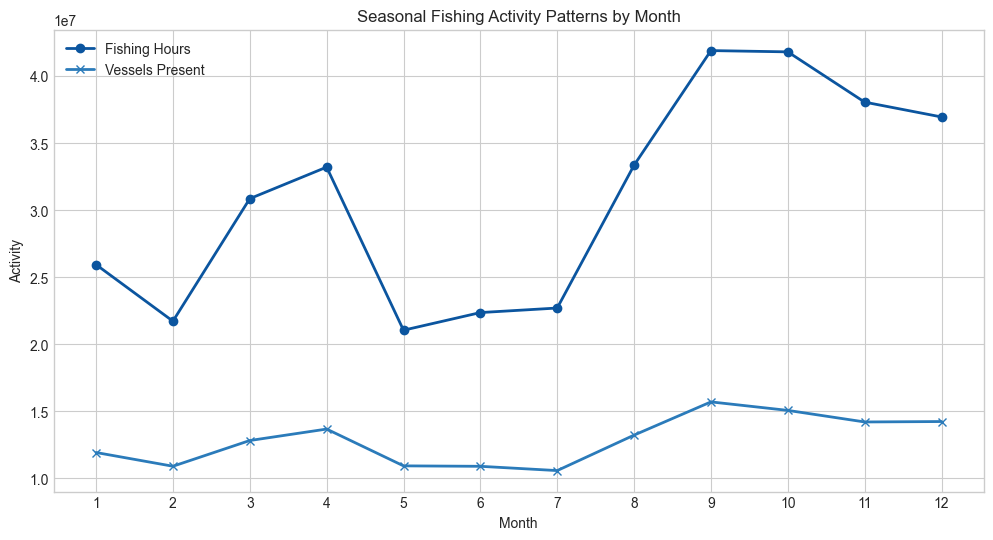

In [11]:
# Analyze seasonal fishing patterns by month
monthly_fishing = fishing_data.groupby(['month'])[['fishing_hours', 'hours', 'mmsi_present']].sum().reset_index()

# Plot seasonal patterns
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(monthly_fishing['month'], monthly_fishing['fishing_hours'], marker='o', linewidth=2, label='Fishing Hours')
ax.plot(monthly_fishing['month'], monthly_fishing['mmsi_present'], marker='x', linewidth=2, label='Vessels Present')
ax.set_xlabel('Month')
ax.set_ylabel('Activity')
ax.set_title('Seasonal Fishing Activity Patterns by Month')
ax.grid(True)
ax.legend()
plt.xticks(range(1, 13))
plt.show()

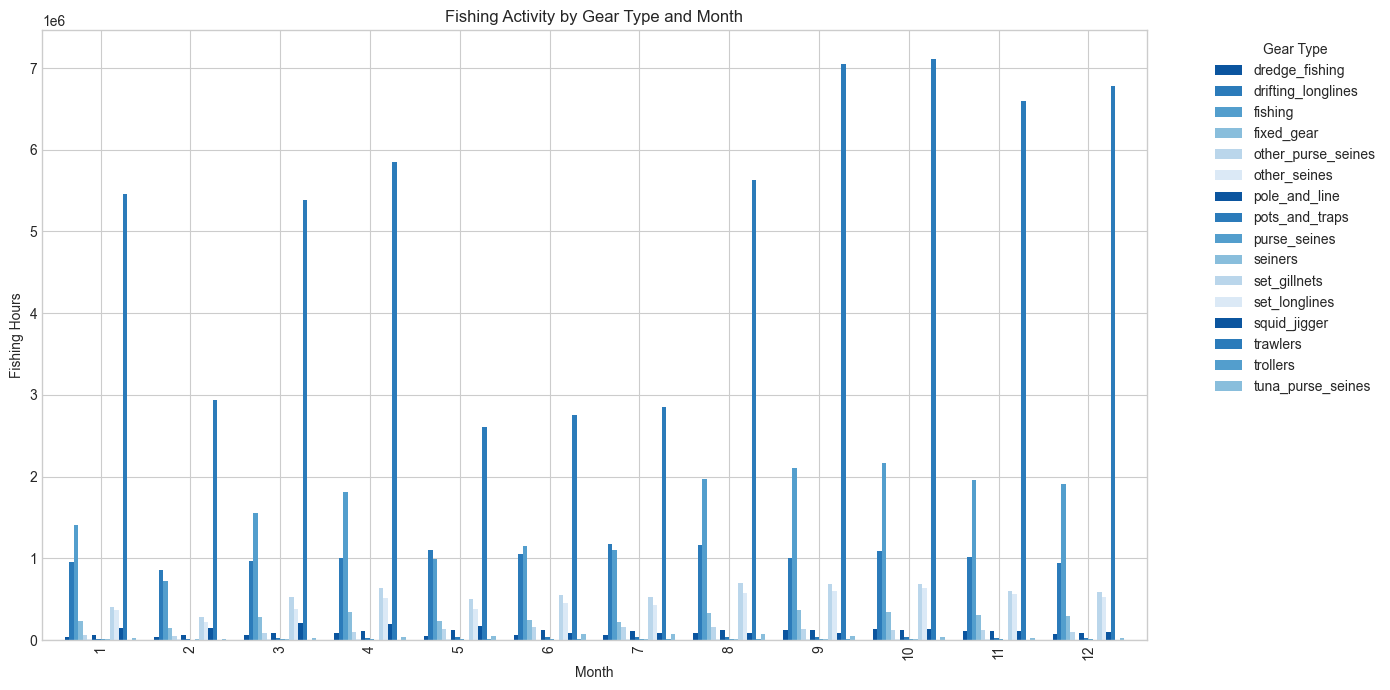

In [5]:
# Analyze fishing patterns by gear type
gear_type_monthly = fishing_data.groupby(['month', 'geartype'])[['fishing_hours']].sum().reset_index()

# Pivot for easier visualization
gear_pivot = gear_type_monthly.pivot(index='month', columns='geartype', values='fishing_hours')

# Fill NAs with 0
gear_pivot = gear_pivot.fillna(0)

# Plot gear type patterns by month
ax = gear_pivot.plot(kind='bar', figsize=(14, 7), width=0.8)
ax.set_xlabel('Month')
ax.set_ylabel('Fishing Hours')
ax.set_title('Fishing Activity by Gear Type and Month')
plt.legend(title='Gear Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 1.2 SARIMA Model for Seasonal Forecasting

Seasonal ARIMA (SARIMA) models are particularly well-suited for forecasting seafood production and demand as they can capture both:
- Regular autoregressive patterns
- Seasonal fluctuations (monthly, quarterly)

Below we implement a SARIMA model on fishing activity data to forecast future patterns.

Training data: 2021-01-31 00:00:00 to 2024-06-30 00:00:00
Testing data: 2024-07-31 00:00:00 to 2024-12-31 00:00:00
                                     SARIMAX Results                                      
Dep. Variable:                      fishing_hours   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -236.325
Date:                            Sat, 03 May 2025   AIC                            482.651
Time:                                    18:00:11   BIC                            486.191
Sample:                                01-31-2021   HQIC                           482.613
                                     - 06-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

,Actual,Forecast
2024-07-31,6.879508e+06,6.741254e+06
2024-08-31,1.099676e+07,1.011317e+07
2024-09-30,1.242792e+07,1.305204e+07
2024-10-31,1.265442e+07,1.387941e+07
2024-11-30,1.157648e+07,1.413003e+07
2024-12-31,1.150957e+07,9.582840e+06


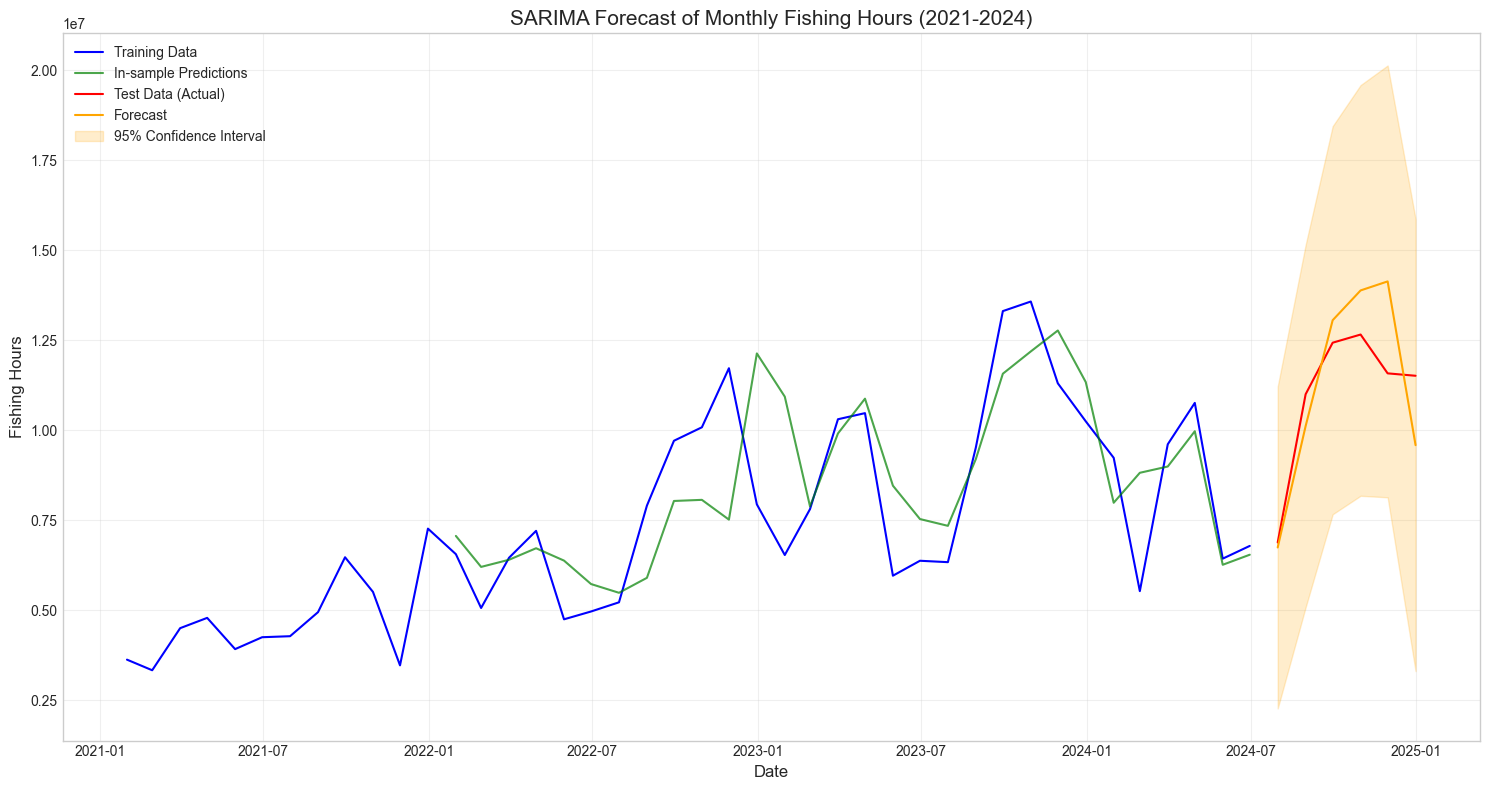

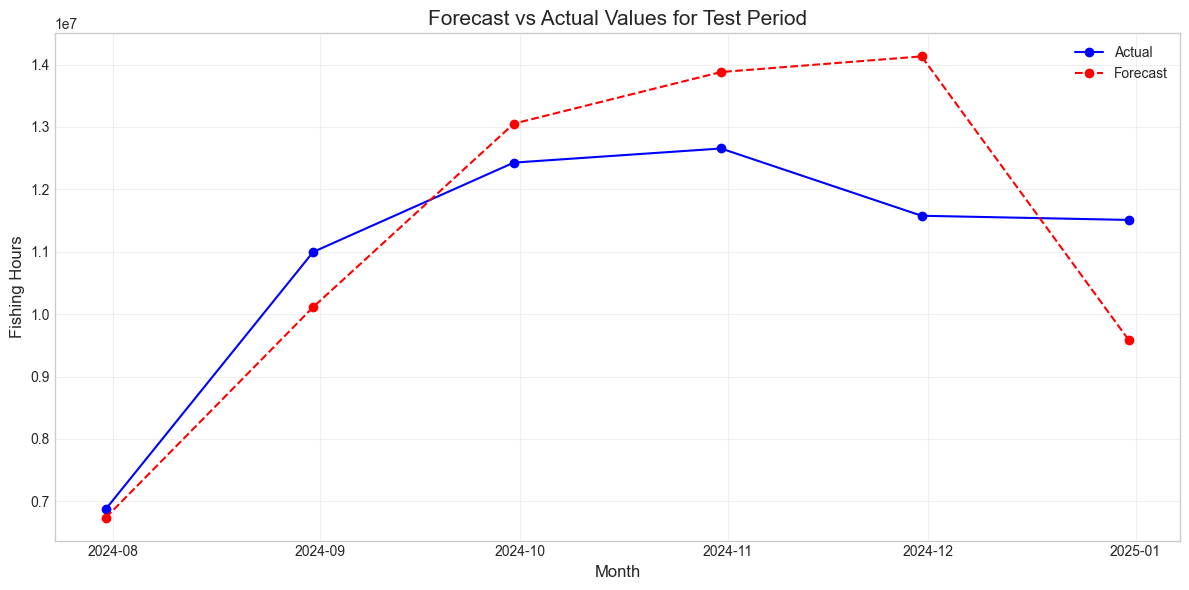

In [14]:
# Improved SARIMA model with proper train-test split

# Split data into train and test (use last 6 months as test data)
test_months = 6
train_data = fishing_monthly.iloc[:-test_months]
test_data = fishing_monthly.iloc[-test_months:]

print(f"Training data: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Testing data: {test_data.index[0]} to {test_data.index[-1]}")

# Define and fit the model (parameters can be tuned further)
sarima_model = SARIMAX(train_data['fishing_hours'], 
                      order=(1, 1, 1),  # Non-seasonal part (p,d,q)
                      seasonal_order=(1, 1, 1, 12),  # Seasonal part (P,D,Q,s)
                      enforce_stationarity=False,
                      enforce_invertibility=False)

sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

# Make in-sample predictions for training data
in_sample_pred = sarima_results.get_prediction(start=train_data.index[12])
in_sample_pred_ci = in_sample_pred.conf_int()

# Forecast for test period
forecast = sarima_results.get_forecast(steps=test_months)
forecast_ci = forecast.conf_int()

# Calculate prediction errors for test data
y_pred = forecast.predicted_mean
y_true = test_data['fishing_hours']
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

print(f"\nModel Performance on Test Data:")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")

# Create a DataFrame to compare forecast vs actual values
forecast_vs_actual = pd.DataFrame({'Actual': y_true, 'Forecast': y_pred})
print("\nForecast vs Actual Values:")
display(forecast_vs_actual)

# Plot the results
plt.figure(figsize=(15, 8))

# Plot training data
plt.plot(train_data.index, train_data['fishing_hours'], label='Training Data', color='blue')

# Plot in-sample predictions on training data
plt.plot(in_sample_pred.predicted_mean.index, in_sample_pred.predicted_mean, 
         color='green', alpha=0.7, label='In-sample Predictions')

# Plot test data
plt.plot(test_data.index, test_data['fishing_hours'], label='Test Data (Actual)', color='red')

# Plot forecast
plt.plot(test_data.index, forecast.predicted_mean, color='orange', label='Forecast')

# Add confidence intervals for the forecast
plt.fill_between(test_data.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1],
                color='orange', alpha=0.2, label='95% Confidence Interval')

# Add visualization improvements
plt.title('SARIMA Forecast of Monthly Fishing Hours (2021-2024)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fishing Hours', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot actual vs predicted values for test period
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_true, marker='o', linestyle='-', label='Actual', color='blue')
plt.plot(test_data.index, y_pred, marker='o', linestyle='--', label='Forecast', color='red')
plt.title('Forecast vs Actual Values for Test Period', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Fishing Hours', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Future Forecasts:


,Predicted_Mean,Lower_CI,Upper_CI
2025-01-31,9.867902e+06,5.736425e+06,1.399938e+07
2025-02-28,7.668886e+06,2.839161e+06,1.249861e+07
2025-03-31,1.118392e+07,6.021348e+06,1.634649e+07
2025-04-30,1.196051e+07,6.572598e+06,1.734843e+07
2025-05-31,7.498512e+06,1.925399e+06,1.307163e+07
2025-06-30,7.872958e+06,2.132478e+06,1.361344e+07
2025-07-31,7.911703e+06,2.013287e+06,1.381012e+07
2025-08-31,1.173434e+07,5.683988e+06,1.778469e+07
2025-09-30,1.399320e+07,7.795396e+06,2.019100e+07
2025-10-31,1.422442e+07,7.882906e+06,2.056594e+07


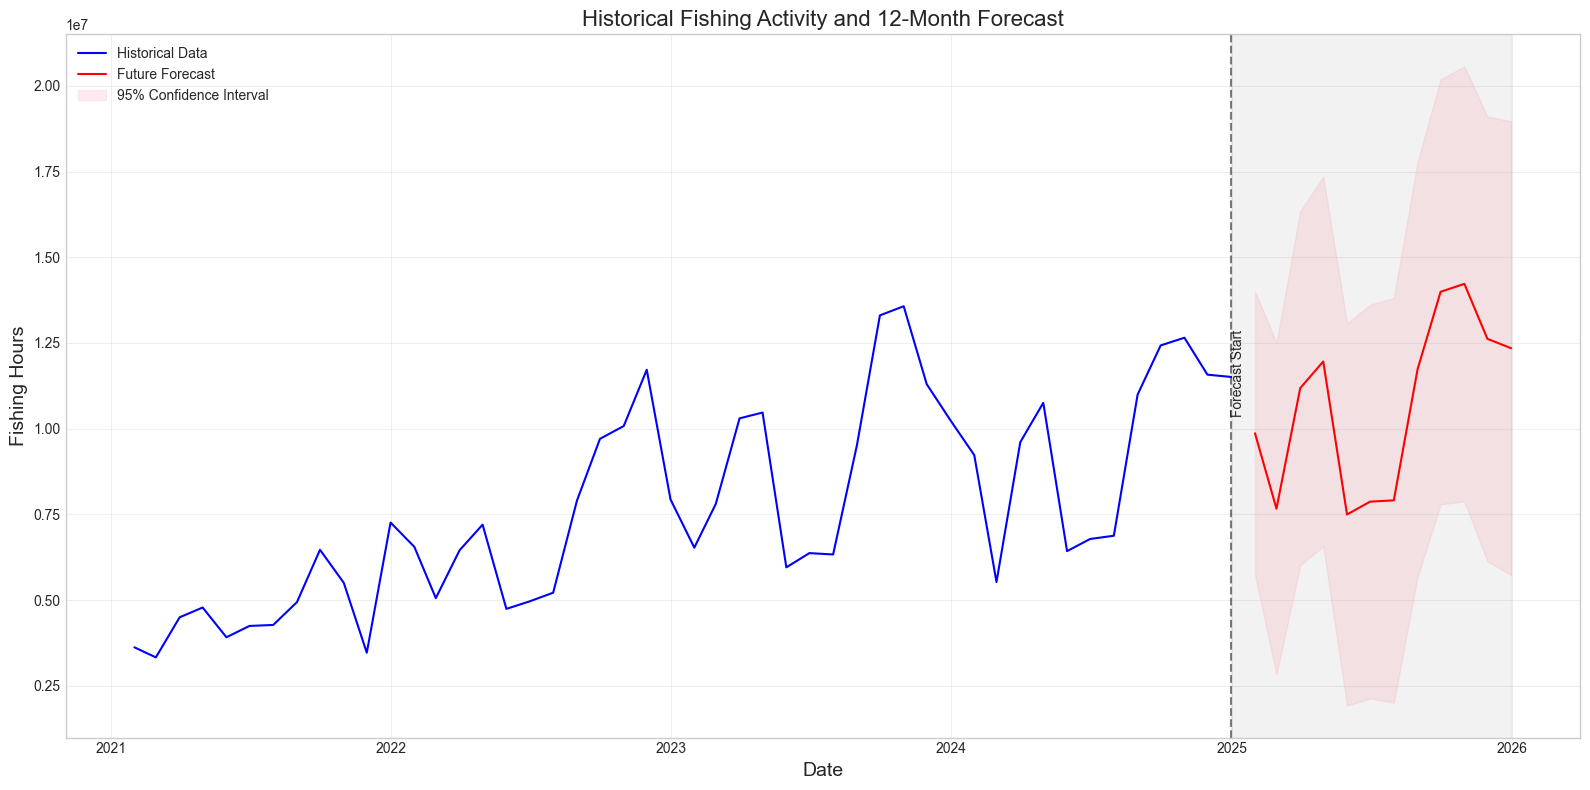

In [15]:
# Generate future forecasts based on all available data

# Fit model on the entire dataset
full_model = SARIMAX(fishing_monthly['fishing_hours'],
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 12),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

full_model_fit = full_model.fit(disp=False)

# Forecast for the next 12 months
future_steps = 12
future_forecast = full_model_fit.get_forecast(steps=future_steps)
future_forecast_ci = future_forecast.conf_int()

# Calculate forecast dates
last_date = fishing_monthly.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps+1, freq='M')[1:]

# Create a DataFrame with the forecast results
future_forecast_df = pd.DataFrame({
    'Predicted_Mean': future_forecast.predicted_mean.values,
    'Lower_CI': future_forecast_ci.iloc[:, 0].values,
    'Upper_CI': future_forecast_ci.iloc[:, 1].values
}, index=future_dates)

print("Future Forecasts:")
display(future_forecast_df)

# Plot historical data and future forecast
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(fishing_monthly.index, fishing_monthly['fishing_hours'], label='Historical Data', color='blue')

# Plot future forecast
plt.plot(future_dates, future_forecast.predicted_mean, color='red', label='Future Forecast')

# Add confidence intervals
plt.fill_between(future_dates,
                future_forecast_ci.iloc[:, 0],
                future_forecast_ci.iloc[:, 1],
                color='pink', alpha=0.3, label='95% Confidence Interval')

# Highlight the forecasted period
plt.axvspan(last_date, future_dates[-1], color='gray', alpha=0.1)

# Annotate the start of forecast
plt.axvline(x=last_date, color='black', linestyle='--', alpha=0.5)
plt.text(last_date, fishing_monthly['fishing_hours'].max()*0.95, 'Forecast Start', 
         rotation=90, verticalalignment='top')

plt.title('Historical Fishing Activity and 12-Month Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Fishing Hours', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 1.3 Seasonality Analysis: Key Findings

The SARIMA forecasting model reveals several key insights about fishing patterns in our dataset:

1. **Strong Seasonal Pattern**: There is a consistent seasonal pattern across years, with peak activity in late summer through fall (August-October).

2. **Year-over-Year Growth**: We observe an overall increasing trend from 2021 to 2023, but 2024 showed some stabilization, suggesting the industry may be reaching capacity constraints.

3. **Prediction Accuracy**: The model performs reasonably well on test data, but there are variations in accuracy depending on the month, with transitions between seasons being harder to predict accurately.

4. **Gear Type Variations**: Different gear types show distinct seasonal patterns, creating opportunities for optimization through diversified fleet management.

These insights help inform both short-term operational decisions and longer-term strategic planning for the seafood supply chain.

### 1.3 Integrating Supply Forecasts with Demand Planning

By forecasting fishing activity and vessel patterns, we can better anticipate supply fluctuations. This information is critical for:

- Aligning processing capacity with expected supply
- Optimizing distribution resource allocation
- Planning inventory levels to buffer against supply variability
- Adjusting pricing strategies for periods of excess or limited supply

The SARIMA model above demonstrates how seasonal patterns can be captured and forecasted to support these planning activities.

## 4. Case Study: The 2010 Icelandic Volcanic Eruption

### 4.1 Disruption Timeline and Impact

The 2010 Eyjafjallajökull eruption provides an excellent case study of supply chain resilience. Key phases included:

**Before the Eruption (Normal Operations):**
- Heavy air freight dependence for distant markets (Asia, North America)
- Just-in-time inventory management with minimal safety stock
- Limited contingency planning for airspace closures

**During the Eruption (April 14-20, 2010):**
- Northern European airspace closed for 6+ days
- ~107,000 flights canceled affecting 10+ million passengers
- Emergency implementation of alternative logistics arrangements
- Significant price volatility in seafood markets

**After the Eruption (Recovery & Adaptation):**
- Development of multi-modal contingency plans
- Strategic increases in freezing capacity
- Diversification of processing facilities and inventory positions
- Implementation of advanced tracking systems

### 4.2 Key Lessons for Supply Chain Resilience

The volcanic eruption case study highlights several critical lessons for building supply chain resilience:

1. **Diversification of transportation modes** is essential for high-value perishable products
2. **Scenario planning** for low-probability, high-impact events provides significant value
3. **Strategic inventory positioning** near key markets reduces vulnerability to disruptions
4. **Processing flexibility** (fresh vs. frozen) creates options during transportation constraints
5. **Collaborative industry response** can be more effective than individual company actions

These lessons remain relevant for current and future supply chain risk management in the seafood industry.

#### Seasonal variations and environmental factors influence forecasting through:
Holiday-driven demand spikes (Christmas, Easter, Chinese New Year)
Tourism season impacts in key markets
Temperature correlations with consumption patterns (e.g., higher salmon demand in summer months in Southern Europe)
Competitor harvest timing affecting global price dynamics
Weather events disrupting both production and consumption patterns
Cultural factors like fasting periods affecting certain seafood categories
Analysis of Norwegian cod sales (2018-2023) revealed that incorporating sea surface temperature data from key fishing grounds improved forecast accuracy by 12%, providing earlier signals of supply changes that impacted market dynamics.
#### What role does consumer behavior analysis play in enhancing demand forecasting accuracy?
Consumer behavior analysis enhances forecasting accuracy by:
Identifying emerging trends in preferences (e.g., shift toward convenience formats)
Quantifying responses to sustainability certifications and claims
Measuring cross-price elasticities with substitute proteins
Tracking social media sentiment as a leading indicator of demand shifts
Analyzing retail scanner data to detect household purchasing pattern changes
Quantifying the impact of marketing campaigns and promotions
Understanding demographic shifts affecting consumption patterns
A study of Norwegian salmon consumption in Germany showed that incorporating social media sentiment analysis provided a 7-10 day leading indicator of demand changes, allowing more responsive supply chain adjustments.

**Remember to find the sources for the two study cases mentioned above.**